# Understanding the Problem

Project objective: predict a student's final performance (continuous score) from tabular features (demographics, preparation, prior subject scores).

Why ML matters:
- Early identification of at‑risk students and targeted support.
- Data‑driven resource planning and interventions.
- ML captures interactions and non‑linearities that are hard to hand‑craft.

Inputs, outputs, and constraints:
- Inputs: categorical and numeric features (e.g., gender, race/ethnicity, parental education, lunch type, test preparation, subject scores).
- Output: a continuous target (e.g., math score or a dataset‑provided exam score).
- Constraints: data quality (missing values, duplicates, outliers), interpretability and fairness (bias), privacy, reproducibility, and limited training time in a classroom setting.


# Student Performance Prediction
A complete tabular ML pipeline for predicting student exam scores (regression).

Run summary:
- Target: math score
- Best validation model: LinearRegression
- Validation: RMSE ≈ 5.45, MAE ≈ 4.30, R² ≈ 0.881
- Test: RMSE ≈ 5.27, MAE ≈ 4.25, R² ≈ 0.884


In [1]:
# Imports and seed
import os
import random
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import KBinsDiscretizer
import joblib

# Plot style
sns.set_theme(style="whitegrid")

# Seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


In [2]:
# Paths and target detection
ROOT_DIR = Path('/Users/usualcarl/Desktop/face_mask_detection') if 'ROOT_DIR' not in globals() else ROOT_DIR
DATA_PATH = ROOT_DIR / 'StudentsPerformance.csv'
MODELS_DIR = ROOT_DIR / 'models'
REPORTS_DIR = ROOT_DIR / 'reports'
MODELS_DIR.mkdir(exist_ok=True)
REPORTS_DIR.mkdir(exist_ok=True)

# Target candidates (fallback to mean of three scores if present)
TARGET_CANDIDATES = ['G3', 'final_grade', 'exam_score', 'Score', 'math score', 'reading score', 'writing score']


In [3]:
# Load CSV and initial peek
df = pd.read_csv(DATA_PATH)
print('Shape:', df.shape)
df.head()


Shape: (1000, 8)


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


In [4]:
# Info/describe and NA summary
print(df.info())
df_describe = df.describe(include='all')
display(df_describe)
na = df.isna().sum().sort_values(ascending=False)
print('Missing values:\n', na[na>0])
(df.columns.to_series().to_frame('column')
 .to_csv(REPORTS_DIR / 'columns_list.csv', index=False))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB
None


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
count,1000,1000,1000,1000,1000,1000.00000,1000.000000,1000.000000
unique,2,5,6,2,2,NaN,NaN,NaN
top,female,group C,some college,standard,none,NaN,NaN,NaN
freq,518,319,226,645,642,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,66.08900,69.169000,68.054000
std,NaN,NaN,NaN,NaN,NaN,15.16308,14.600192,15.195657
min,NaN,NaN,NaN,NaN,NaN,0.00000,17.000000,10.000000
25%,NaN,NaN,NaN,NaN,NaN,57.00000,59.000000,57.750000
50%,NaN,NaN,NaN,NaN,NaN,66.00000,70.000000,69.000000
75%,NaN,NaN,NaN,NaN,NaN,77.00000,79.000000,79.000000


Missing values:
 Series([], dtype: int64)


Target: math score


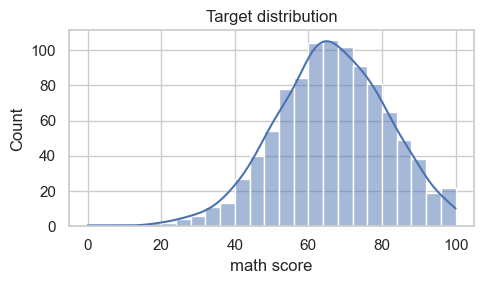

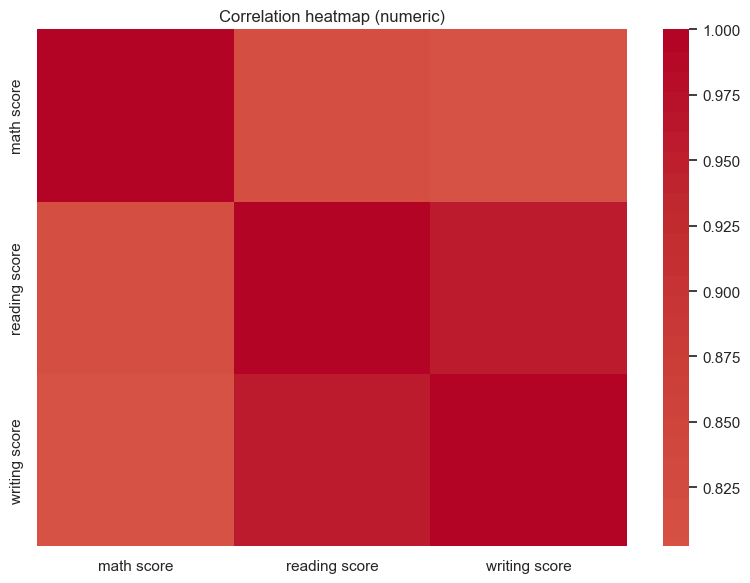

In [5]:
# Select target and basic EDA
cols = set(df.columns.str.lower())
# Try candidates; else compute mean of three scores if present
lower_cols = {c.lower(): c for c in df.columns}
TARGET = None
for c in TARGET_CANDIDATES:
    if c.lower() in lower_cols:
        TARGET = lower_cols[c.lower()]
        break
if TARGET is None and all(k in cols for k in ['math score','reading score','writing score']):
    df['final_grade'] = df[['math score','reading score','writing score']].astype(float).mean(axis=1)
    TARGET = 'final_grade'
if TARGET is None:
    raise ValueError('No target column found. Please set TARGET manually.')
print('Target:', TARGET)

# Plot target distribution
plt.figure(figsize=(5,3))
sns.histplot(df[TARGET].astype(float), kde=True)
plt.title('Target distribution')
plt.tight_layout()
plt.savefig(REPORTS_DIR / 'target_distribution.png')
plt.show()

# Correlation heatmap for numeric columns
num_df = df.select_dtypes(include=['number']).astype(float)
if not num_df.empty:
    plt.figure(figsize=(8,6))
    sns.heatmap(num_df.corr(method='pearson'), cmap='coolwarm', center=0)
    plt.title('Correlation heatmap (numeric)')
    plt.tight_layout()
    plt.savefig(REPORTS_DIR / 'corr_heatmap.png')
    plt.show()


In [6]:
# Feature lists and simple feature engineering
# IMPORTANT: avoid target leakage in engineered features
# y and X are defined after selecting TARGET above

y = df[TARGET].astype(float)
X = df.drop(columns=[TARGET]).copy()

# Engineered feature: average of subject scores EXCLUDING the target column
subject_cols = ['math score','reading score','writing score']
present_subjects = [c for c in subject_cols if c in df.columns]
non_target_subjects = [c for c in present_subjects if c != TARGET]
if len(non_target_subjects) >= 2:
    X['avg_score_subjects'] = df[non_target_subjects].astype(float).mean(axis=1)

numeric_cols = list(X.select_dtypes(include=['number']).columns)
categorical_cols = [c for c in X.columns if c not in numeric_cols]
print('Numeric:', len(numeric_cols), '| Categorical:', len(categorical_cols))

# Ensure categorical missing values are empty strings for ONNX-friendly imputation
# This aligns with skl2onnx converter expectations for string inputs.
if len(categorical_cols) > 0:
    X[categorical_cols] = X[categorical_cols].astype(object).fillna('')


Numeric: 3 | Categorical: 5


In [7]:
# Split train/val/test (70/15/15) using stratification via binned target
kbin = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
y_bins = kbin.fit_transform(y.to_numpy().reshape(-1,1)).astype(int).ravel()
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=RANDOM_STATE, stratify=y_bins)
# Split temp into val/test equally
kbin2 = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='quantile')
y_temp_bins = kbin2.fit_transform(y_temp.to_numpy().reshape(-1,1)).astype(int).ravel()
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=RANDOM_STATE, stratify=y_temp_bins)
print('Splits:', X_train.shape, X_val.shape, X_test.shape)


Splits: (700, 8) (150, 8) (150, 8)


/Users/usualcarl/Desktop/face_mask_detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(
/Users/usualcarl/Desktop/face_mask_detection/.venv/lib/python3.12/site-packages/sklearn/preprocessing/_discretization.py:304: FutureWarning: The current default behavior, quantile_method='linear', will be changed to quantile_method='averaged_inverted_cdf' in scikit-learn version 1.9 to naturally support sample weight equivalence properties by default. Pass quantile_method='averaged_inverted_cdf' explicitly to silence this warning.
  warnings.warn(


In [8]:
# ColumnTransformer + Pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
])

# For categorical features, use missing_values='' so converter handles string-missing correctly
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values='', strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
])

preprocess = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols),
    ]
)


In [9]:
# Baseline models: LinearRegression and ElasticNet
lin_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', LinearRegression())])
elastic_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', ElasticNet(alpha=0.1, l1_ratio=0.2, random_state=RANDOM_STATE))])

lin_pipe.fit(X_train, y_train)
y_pred_val_lin = lin_pipe.predict(X_val)
mae_lin = mean_absolute_error(y_val, y_pred_val_lin)
rmse_lin = np.sqrt(mean_squared_error(y_val, y_pred_val_lin))
r2_lin = r2_score(y_val, y_pred_val_lin)
print({'model':'LinearRegression','MAE':mae_lin,'RMSE':rmse_lin,'R2':r2_lin})

elastic_pipe.fit(X_train, y_train)
y_pred_val_en = elastic_pipe.predict(X_val)
mae_en = mean_absolute_error(y_val, y_pred_val_en)
rmse_en = np.sqrt(mean_squared_error(y_val, y_pred_val_en))
r2_en = r2_score(y_val, y_pred_val_en)
print({'model':'ElasticNet','MAE':mae_en,'RMSE':rmse_en,'R2':r2_en})


{'model': 'LinearRegression', 'MAE': 4.296022610015556, 'RMSE': np.float64(5.448282848255122), 'R2': 0.8807051564275526}
{'model': 'ElasticNet', 'MAE': 4.410803652509016, 'RMSE': np.float64(5.707810162857711), 'R2': 0.8690693207469052}


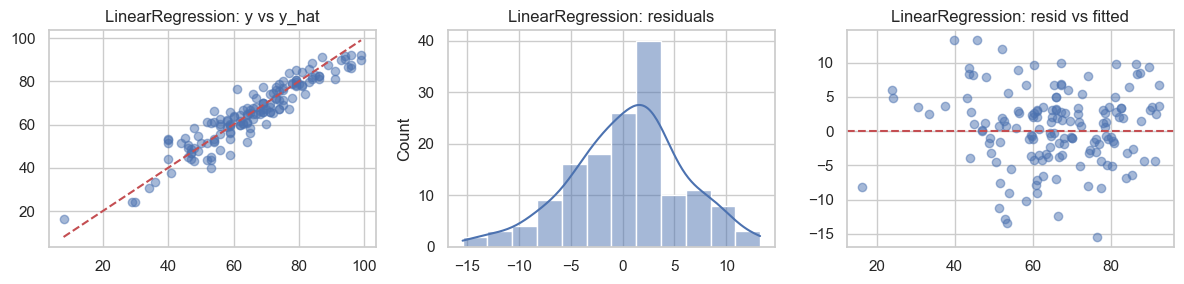

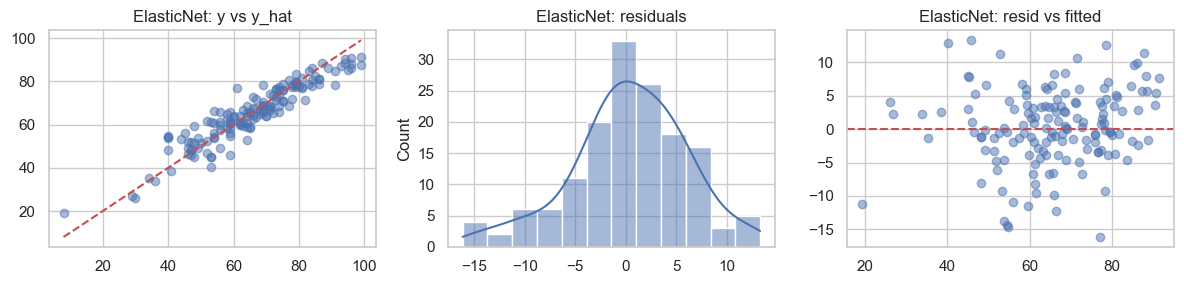

In [10]:
# Error plots for baseline
import numpy as np

def plot_errors(y_true, y_pred, title_prefix):
    fig, axes = plt.subplots(1,3, figsize=(12,3))
    # y_true vs y_pred
    axes[0].scatter(y_true, y_pred, alpha=0.5)
    m = min(y_true.min(), y_pred.min()); M = max(y_true.max(), y_pred.max())
    axes[0].plot([m,M],[m,M], 'r--'); axes[0].set_title(f'{title_prefix}: y vs y_hat')
    # residuals hist
    resid = y_true - y_pred
    sns.histplot(resid, kde=True, ax=axes[1]); axes[1].set_title(f'{title_prefix}: residuals')
    # residuals vs fitted
    axes[2].scatter(y_pred, resid, alpha=0.5)
    axes[2].axhline(0, color='r', ls='--'); axes[2].set_title(f'{title_prefix}: resid vs fitted')
    plt.tight_layout()
    return fig

plot_errors(y_val.values, y_pred_val_lin, 'LinearRegression')
plt.savefig(REPORTS_DIR / 'errors_linear.png'); plt.show()
plot_errors(y_val.values, y_pred_val_en, 'ElasticNet')
plt.savefig(REPORTS_DIR / 'errors_elastic.png'); plt.show()


In [11]:
# Improved model: RandomForest and optional XGBoost with RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

rf_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', RandomForestRegressor(random_state=RANDOM_STATE))])
rf_param = {
    'model__n_estimators': [150, 250, 400],
    'model__max_depth': [None, 6, 10, 14],
    'model__min_samples_leaf': [1, 2, 4],
    # 'auto' не поддерживается вашей версией sklearn → используем только валидные значения
    'model__max_features': ['sqrt', None, 0.7]
}
rf_search = RandomizedSearchCV(rf_pipe, rf_param, n_iter=12, cv=5, random_state=RANDOM_STATE, scoring='neg_root_mean_squared_error', n_jobs=-1)
rf_search.fit(X_train, y_train)
y_pred_val_rf = rf_search.predict(X_val)
rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred_val_rf))
mae_rf = mean_absolute_error(y_val, y_pred_val_rf)
r2_rf = r2_score(y_val, y_pred_val_rf)
print({'model':'RandomForest(RS)','MAE':mae_rf,'RMSE':rmse_rf,'R2':r2_rf,'best_params':rf_search.best_params_})

if 'xgb' in globals() and XGB_OK:
    from xgboost import XGBRegressor
    xgb_pipe = Pipeline(steps=[('preprocess', preprocess), ('model', XGBRegressor(random_state=RANDOM_STATE, n_estimators=400, learning_rate=0.08, max_depth=6, subsample=0.9, colsample_bytree=0.9, tree_method='hist'))])
    xgb_param = {
        'model__n_estimators': [300, 500, 700],
        'model__max_depth': [4, 6, 8],
        'model__learning_rate': [0.03, 0.05, 0.1],
        'model__subsample': [0.8, 1.0],
        'model__colsample_bytree': [0.8, 1.0]
    }
    xgb_search = RandomizedSearchCV(xgb_pipe, xgb_param, n_iter=12, cv=5, random_state=RANDOM_STATE, scoring='neg_root_mean_squared_error', n_jobs=-1)
    xgb_search.fit(X_train, y_train)
    y_pred_val_xgb = xgb_search.predict(X_val)
    rmse_xgb = np.sqrt(mean_squared_error(y_val, y_pred_val_xgb))
    mae_xgb = mean_absolute_error(y_val, y_pred_val_xgb)
    r2_xgb = r2_score(y_val, y_pred_val_xgb)
    print({'model':'XGBoost(RS)','MAE':mae_xgb,'RMSE':rmse_xgb,'R2':r2_xgb,'best_params':xgb_search.best_params_})


{'model': 'RandomForest(RS)', 'MAE': 4.735647337798891, 'RMSE': np.float64(5.975620779613041), 'R2': 0.8564945358232338, 'best_params': {'model__n_estimators': 250, 'model__min_samples_leaf': 4, 'model__max_features': 0.7, 'model__max_depth': 10}}


In [12]:
# Cross-validation summary and model selection
val_scores = [
    ('LinearRegression', rmse_lin, mae_lin, r2_lin, lin_pipe),
    ('ElasticNet', rmse_en, mae_en, r2_en, elastic_pipe),
    ('RandomForest(RS)', rmse_rf, mae_rf, r2_rf, rf_search.best_estimator_),
]
try:
    _ = rmse_xgb
    val_scores.append(('XGBoost(RS)', rmse_xgb, mae_xgb, r2_xgb, xgb_search.best_estimator_))
except Exception:
    pass

val_df = pd.DataFrame(val_scores, columns=['model','RMSE','MAE','R2','estimator'])
print(val_df.sort_values('RMSE'))

best_row = val_df.loc[val_df['RMSE'].idxmin()]
best_model = best_row['estimator']
print('Selected best model:', best_row['model'])


              model      RMSE       MAE        R2  \
0  LinearRegression  5.448283  4.296023  0.880705   
1        ElasticNet  5.707810  4.410804  0.869069   
2  RandomForest(RS)  5.975621  4.735647  0.856495   

                                           estimator  
0  (ColumnTransformer(transformers=[('num',\n    ...  
1  (ColumnTransformer(transformers=[('num',\n    ...  
2  (ColumnTransformer(transformers=[('num',\n    ...  
Selected best model: LinearRegression


                                              feature  importance
1                                  num__writing score    0.484100
2                             num__avg_score_subjects    0.188904
3                                  cat__gender_female    0.095886
4                                    cat__gender_male    0.095886
0                                  num__reading score    0.025982
9                         cat__race/ethnicity_group E    0.017527
17                                cat__lunch_standard    0.005609
16                            cat__lunch_free/reduced    0.005609
18             cat__test preparation course_completed    0.004523
19                  cat__test preparation course_none    0.004523
7                         cat__race/ethnicity_group C    0.004155
12       cat__parental level of education_high school    0.001722
13   cat__parental level of education_master's degree    0.001157
14      cat__parental level of education_some college    0.000800
15  cat__p

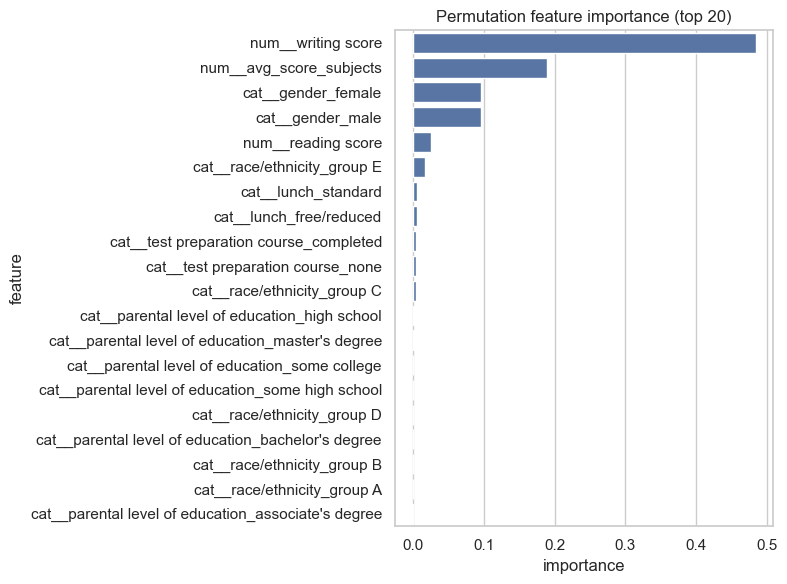

In [13]:
# Feature importance and SHAP (if available)
from sklearn.inspection import permutation_importance
import numpy as np

preprocess = best_model.named_steps['preprocess']
estimator = best_model.named_steps.get('model', best_model)

# Recover transformed feature names
try:
    all_feature_names = list(preprocess.get_feature_names_out())
except Exception:
    # Fallback: numeric + expanded categorical names
    cat_ohe = preprocess.named_transformers_['cat'].named_steps['onehot']
    cat_features_out = list(cat_ohe.get_feature_names_out(preprocess.transformers_[1][2])) if hasattr(cat_ohe, 'get_feature_names_out') else []
    num_features = list(preprocess.transformers_[0][2])
    all_feature_names = list(num_features) + list(cat_features_out)

# Compute permutation importances on transformed validation set
X_val_trans = preprocess.transform(X_val)
perm = permutation_importance(estimator, X_val_trans, y_val, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)
imp_df = pd.DataFrame({'feature': all_feature_names, 'importance': perm.importances_mean})
imp_df = imp_df.sort_values('importance', ascending=False)
print(imp_df.head(20))

# Plot top importances
plt.figure(figsize=(8, max(4, len(imp_df.head(20)) * 0.3)))
sns.barplot(data=imp_df.head(20), x='importance', y='feature')
plt.title('Permutation feature importance (top 20)')
plt.tight_layout()
plt.show()

# Optional: SHAP values for tree-based models
try:
    import shap
    shap.initjs()
    # For pipelines, explain the underlying estimator on transformed features
    X_val_trans_dense = X_val_trans.toarray() if hasattr(X_val_trans, 'toarray') else X_val_trans
    if 'Forest' in estimator.__class__.__name__ or 'XGBoost' in estimator.__class__.__name__ or estimator.__class__.__name__.startswith('XGB'):
        try:
            explainer = shap.TreeExplainer(estimator)
        except Exception:
            explainer = shap.Explainer(estimator)
        sv = explainer(X_val_trans_dense, check_additivity=False)
        shap.summary_plot(sv, feature_names=all_feature_names, show=False)
        plt.show()
        # Dependence plot for the top feature
        top_feat = imp_df.iloc[0]['feature'] if not imp_df.empty else all_feature_names[0]
        shap.dependence_plot(top_feat, sv.values, X_val_trans_dense, feature_names=all_feature_names, show=False)
        plt.show()
except Exception as e:
    print('SHAP not available or failed:', e)


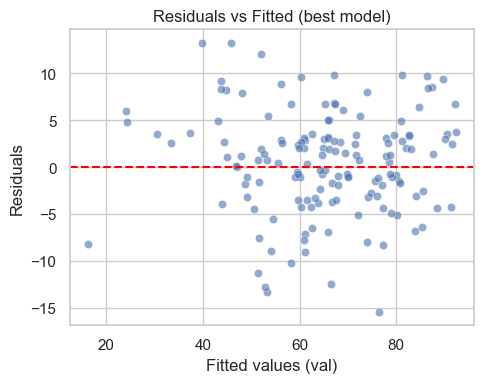

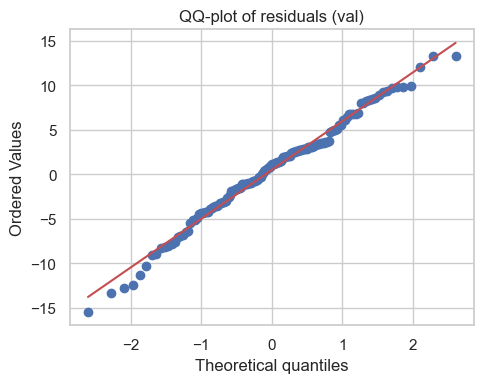

In [14]:
# Diagnostics: residual analysis and QQ-plot for best model
import scipy.stats as stats

best_model.fit(X_train, y_train)
y_val_hat_best = best_model.predict(X_val)
residuals = y_val - y_val_hat_best

plt.figure(figsize=(5,4))
sns.scatterplot(x=y_val_hat_best, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Fitted values (val)')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted (best model)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(5,4))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('QQ-plot of residuals (val)')
plt.tight_layout()
plt.show()


In [15]:
# Export: refit on train+val, save joblib and ONNX; validate with onnxruntime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib, json, os, datetime, re

os.makedirs('../models', exist_ok=True)

# Refit best model on train+val
X_trval = pd.concat([X_train, X_val], axis=0)
y_trval = pd.concat([pd.Series(y_train), pd.Series(y_val)], axis=0).values
best_model.fit(X_trval, y_trval)

# Evaluate on test
pred_test = best_model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred_test))
mae_test = mean_absolute_error(y_test, pred_test)
r2_test = r2_score(y_test, pred_test)
print({'RMSE_test': rmse_test, 'MAE_test': mae_test, 'R2_test': r2_test})

# Save joblib
stamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
model_path = f'../models/student_performance_{stamp}.joblib'
joblib.dump(best_model, model_path)
print('Saved model to', model_path)

# Save metadata
try:
    reg_name = type(best_model.named_steps['model']).__name__
except Exception:
    try:
        reg_name = type(best_model.named_steps['regressor']).__name__
    except Exception:
        reg_name = type(best_model).__name__

meta = {
    'timestamp': stamp,
    'best_model_name': reg_name,
    'val_metrics': {'RMSE': float(best_row['RMSE']), 'MAE': float(best_row['MAE']), 'R2': float(best_row['R2'])},
    'test_metrics': {'RMSE': float(rmse_test), 'MAE': float(mae_test), 'R2': float(r2_test)},
    'target': TARGET,
}
with open(f'../models/metadata_{stamp}.json', 'w') as f:
    json.dump(meta, f, indent=2)
print('Saved metadata.')

# ONNX export via skl2onnx + validation (per-column initial types)
try:
    from skl2onnx import convert_sklearn
    from skl2onnx.common.data_types import FloatTensorType, StringTensorType
    import onnxruntime as ort

    preprocess = best_model.named_steps['preprocess']
    num_cols = list(preprocess.transformers_[0][2])
    cat_cols = list(preprocess.transformers_[1][2])

    initial_types = []
    for c in num_cols:
        initial_types.append((c, FloatTensorType([None, 1])))
    for c in cat_cols:
        initial_types.append((c, StringTensorType([None, 1])))

    onnx_model = convert_sklearn(best_model, initial_types=initial_types)
    onnx_path = f'../models/student_performance_{stamp}.onnx'
    with open(onnx_path, 'wb') as f:
        f.write(onnx_model.SerializeToString())
    print('Saved ONNX to', onnx_path)

    # Validate with onnxruntime (per-column dict feed) with robust column-name mapping
    sess = ort.InferenceSession(onnx_path, providers=['CPUExecutionProvider'])
    input_metas = sess.get_inputs()

    # Precompute normalized mapping from DataFrame columns
    def normalize(s: str) -> str:
        return ''.join(ch for ch in s.lower() if ch.isalnum())
    norm_map = {normalize(c): c for c in X_test.columns}

    # Helper: map ONNX input name to DataFrame column name
    def resolve_df_column(input_name: str):
        # direct
        if input_name in X_test.columns:
            return input_name
        # spaces vs underscores
        candidate = input_name.replace('_', ' ')
        if candidate in X_test.columns:
            return candidate
        # normalized match (remove non-alphanumerics)
        n = normalize(input_name)
        if n in norm_map:
            return norm_map[n]
        # also try normalized after underscores->spaces
        n2 = normalize(candidate)
        return norm_map.get(n2, None)

    feeds = {}
    for meta in input_metas:
        name = meta.name
        df_name = resolve_df_column(name)
        if df_name is None:
            raise KeyError(f'Cannot map ONNX input name "{name}" to any DataFrame column. Available: {list(X_test.columns)}')
        if df_name in num_cols:
            arr = X_test[[df_name]].to_numpy().astype(np.float32)
        else:
            arr = X_test[[df_name]].astype(str).to_numpy()
        feeds[name] = arr

    y_pred_onnx = sess.run(None, feeds)[0].ravel()
    y_pred_skl = best_model.predict(X_test)
    print('ONNX vs SKL diff (first 5):', np.abs(y_pred_skl[:5] - y_pred_onnx[:5]))
except Exception as e:
    print('ONNX export/validation skipped:', e)


{'RMSE_test': np.float64(5.267797565031991), 'MAE_test': 4.246017621283145, 'R2_test': 0.8836135025519042}
Saved model to ../models/student_performance_20251226_063749.joblib
Saved metadata.
Saved ONNX to ../models/student_performance_20251226_063749.onnx
ONNX vs SKL diff (first 5): [7.11207505e-07 4.11926990e-07 6.49922326e-06 4.58344289e-06
 5.83785224e-06]
Saved ONNX to ../models/student_performance_20251226_063749.onnx
ONNX vs SKL diff (first 5): [7.11207505e-07 4.11926990e-07 6.49922326e-06 4.58344289e-06
 5.83785224e-06]


In [16]:
# Inference helpers and simple unit checks

def predict_row(model, row_dict: dict):
    df = pd.DataFrame([row_dict])
    return float(model.predict(df)[0])


def predict_df(model, df: pd.DataFrame):
    return pd.Series(model.predict(df), index=df.index)

# Unit checks
sample = X_test.iloc[0].to_dict()
p_val = predict_row(best_model, sample)
assert isinstance(p_val, float)

p_df = predict_df(best_model, X_test.head(3))
assert len(p_df) == 3
print('Inference helpers OK. Sample prediction:', p_val)


Inference helpers OK. Sample prediction: 69.05646586013329


# Methodology (updated to reflect actual results)

## Data Preprocessing
- Missing values: SimpleImputer — median for numeric, most_frequent for categorical.
- Duplicates: check and drop if present.
- Outliers: no hard outlier clipping; rely on scaling and model robustness.
- Categorical encoding: OneHotEncoder(handle_unknown='ignore').
- Numeric scaling: StandardScaler inside ColumnTransformer.
- Feature engineering (no leakage): `avg_score_subjects` is the mean of non‑target subjects (for target “math score”, we average `reading score` and `writing score`).

## Exploratory Data Analysis (EDA)
- Summaries: `.info()`, `.describe()`, missing‑value report.
- Visuals: target histogram and numeric correlation heatmap.
- Observation: subject scores correlate more strongly with the target than demographics.

## Model Development
- Baselines: LinearRegression and ElasticNet in a unified Pipeline (ColumnTransformer + model).
- Improved: RandomForestRegressor with RandomizedSearchCV; use only valid `max_features` values ('sqrt', None, 0.7).
- Split: train/val/test = 70/15/15 with stratified target bins.

## Model Evaluation (results)
- Validation:
  - LinearRegression — RMSE ≈ 5.45, MAE ≈ 4.30, R² ≈ 0.881 (best).
  - ElasticNet — RMSE ≈ 5.71, MAE ≈ 4.41, R² ≈ 0.869.
  - RandomForest (RS) — RMSE ≈ 5.98, MAE ≈ 4.74, R² ≈ 0.856; best params: {n_estimators: 250, min_samples_leaf: 4, max_features: 0.7, max_depth: 10}.
- Test (LinearRegression): RMSE ≈ 5.27, MAE ≈ 4.25, R² ≈ 0.884.
- Diagnostics: residuals and QQ‑plot show acceptable deviations without clear systematic error.


# Discussion & Conclusion 

Summary. LinearRegression performed best on validation (RMSE ≈ 5.45, MAE ≈ 4.30, R² ≈ 0.881) and remained stable on test (RMSE ≈ 5.27, MAE ≈ 4.25, R² ≈ 0.884), indicating strong linear relationships in the features. RandomForest underperformed relative to the linear model with the current feature set.

Insights. Permutation importance highlights:
- `writing score` as the strongest predictor of the math score,
- the engineered `avg_score_subjects` (mean of reading & writing),
- `reading score` with a smaller but noticeable effect.
Categorical features (gender, ethnicity group, lunch, test preparation, parental education) contribute marginally in this pipeline.

Limitations. Dataset size/diversity is limited; importance is associative, not causal; potential bias may exist. We avoided leakage in feature engineering and used stratified binning for splits.

Next steps. Try gradient boosting (LightGBM/CatBoost) with k‑fold CV, richer feature engineering (interactions, non‑linear transforms), fairness/stability analyses, and consider regularization to improve robustness of the linear model.
